# Exploring long-term urban changes through satellite imagery

### Meixu Chen $^{1}$, Dominik Fahrner $^{2,3}$, Daniel Arribas-Bel$^{1}$, Francisco Rowe $^{1}$

$^{1}$ Geographic Data Science Lab, Department of Geography and Planning, University of Liverpool, Roxby Building, 74 Bedford St S, Liverpool, L69 7ZT, United Kingdom

$^{2}$ Department of Geography annd Planning, School of Environmental Sciences, University of Liverpool, Liverpool, L69 7ZT, United Kingdom

$^{3}$ Institute for Risk and Uncertainty, University of Liverpool, Chadwick Building, Peach Street, Liverpool, L7 7BD, United Kingdom

## Abstract

Satellite imagery is often used to study and monitor Earth surface changes. The open availability and extensive temporal coverage of Landsat imagery has enabled changes in temperature, wind, vegetation and ice melting speed for a period of up to 46 years. Yet, the use of satellite imagery to study cities has remained underutilised, partly due to the lack of a methodological approach to capture features and changes in the urban environment. This notebook offers a framework based on Python tools to demonstrate how to batch-download high-resolution satellite imagery; and enable the extraction, analysis and visualisation of features of the built environment to capture long-term urban changes.



**Keywords:** satellite imagery, image segmentation, urbanisation, cities, urban change, computational notebooks

## Table of Contents 

1. [Introduction](#Introduction)
2. [Data and Study Area](#Data)
    * [Landsat](#Landsat)
    * [Study Area](#Study-area)
    * [Data download and pre-processing](#Data-download-and-pre-processing)
3. [Feature extraction](#Feature-extraction)
    * [Colour features](#Colour-features)
    * [Texture features](#Texture-features)
    * [Vegetation features](#Vegetation-features)
    * [Built-up features](#Built-up-features)
4. [Feature clustering](#Feature-clustering)
5. [Result interpretation](#Result-interpretation)
6. [Conclusion](#Conclusion)
7. [References](#References)

### Introduction 

Sustainable urban habitats are a key component of many global challenges. Efficient management and planning of cities are pivotal to all 17 UN Sustainable Development Goals (SDGs). Over 90% of the projected urban population growth by 2050 will occur in less developed countries (UN, 2019). Concentrated in cities, this growth offers an opportunity for social progress and economic development but it also imposes major challenges for urban planning. Prior work on urbanisation has identified the benefits of agglomeration and improvements in health and education, which tend to outweigh the costs of congestion, pollution and poverty (Glaeser and Henderson, 2017). Yet research has remained largely focused on Western cities, developing a good understanding of urban areas in high-income, developed countries (Glaeser and Henderson, 2017). Much less is known about urban habitats in less developed countries. This gap is partly due to the lack of comprehensive data sources capturing the dynamics of urban structures in less developed countries.

Cities in Asia provide a unique setting to explore the challenges triggered by rapid urbanisation. The share of urban population in Asia is currently at turning point transitioning to exceed the share of rural population. Currently Asia is home to over 53% of the urban population globally and the share of urban population is projected to increase to 66% by 2050 (UN, 2019). Developing monitoring tools to understand the past and current urbanisation process is key to guide appropriate urban planning and policy strategies.

Recent technological developments can help overcome the paucity in spatially-detailed
urban data in less developed countries. The combination of geospatial technology, cheap
computing and new machine learning algorithms has ushered in an age of new
forms of data, producing brand new data sets and repurposing existing sources.
Satellite imagery represents a key source of information. Photographs from the sky have existed for
decades, but their use in the context of socioeconomic urban research has been
limited. Image data has been hard to process and understand for social scientists.
Yet recent developments in machine learning and artificial intelligence have made images computable and
turned these data into brand new information to be explored by quantitative urban
researchers. Satellite data can be openly accessible, provide high temporal and a global coverage at a reasonably high spatial resolution. 

This notebook illustrates an analytical framework based on Python tools which enables batch download, image feature extraction, analysis and visualisation of high-resolution satellite imagery to capture long-term urban changes. The source of satellite data and administritive boundaries data are from NASA's Landset satellite programme and ArcGIS Online. The Python libraries used in this notebook are the following:

* [Landsat images in Google Cloud Storage](https://cloud.google.com/storage/docs/public-datasets/landsat): The Google Cloud Storage is accessed using an API to download Landsat imagery
* [Matplotolib](https://matplotlib.org/contents.html):A Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms. 
* [Numpy](https://docs.scipy.org/doc/): Adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions
* [Pandas](https://pandas.pydata.org/pandas-docs/stable/):  Provides high-performance, easy-to-use data structures and data analysis tools 
* [GeoPandas](http://geopandas.org/): Python library that simplifies working with geospatil data
* [Folium](http://folium.readthedocs.io/en/latest/): Python library that enables plotting interactive maps using leaflet
* [Glob](https://docs.python.org/2/library/glob.html): Unix style pathname pattern expansion
* [GDAL](https://gdal.org/): Library for geospatial data processing
* [Landsat578](https://github.com/dgketchum/Landsat578): Simple Landsat imagery download tool
* [L8qa](https://github.com/mapbox/rio-l8qa/blob/master/README.md): Landsat processing toolbox
* [Rasterio](https://rasterio.readthedocs.io/en/stable/): Library for raster data processing
* [Scikit-image](http://scikit-image.org/docs/dev/): Collection of algorithms for image processing
* [Wget](https://pypi.org/project/wget/): Pure python download utility
* [OpenCV](https://pypi.org/project/opencv-python/): Library for image processing
* [scikit-learn](https://scikit-learn.org/stable/index.html): Machine learning in Python. Simple and efficient tools for data mining and data analysis.

We can import them al as follows:

In [1]:
%matplotlib inline

#load external libraries
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import os, shutil
import glob
import gdal
import wget
from landsat import google_download
from google_download import GoogleDownload
from l8qa.qa import write_cloud_mask
import rasterio
import rasterio as rio
from rasterio import merge 
from rasterio.plot import show
from rasterio.mask import mask
from skimage import io,exposure, transform,data
from skimage.color import rgb2hsv, rgb2gray
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn import preprocessing
from rasterio.enums import Resampling
import seaborn as sns

wdir= os.getcwd()

The remainder of this paper is structured as follows. The next section introduces the Landset satellite imagery, study area Shanghai, and process on how to batch download and pre-process satellite data. Section 3 proposes our methods to extract different features including colour,texture, vegetation and built-up from imagery. Section 4 performs clustering method on the extracted features, and section 5 interprets the results and gain insights from them. Finally, section 5 concludes by providing a summary of our work and avenues for further reserach using our proposed framework.

### Data and Study Area

#### Landsat Imagery
We draw data from the NASA's Landsat satellite programme. It is the longest standing programme for Earth observation (EO) imagery (NASA, 2019). Landsat satellites have been orbiting the Earth for 46 years providing increasingly higher resolution imagery. Landsat Missions 1-3 offer coarse imagery of 80m covering the period from 1972 to 1983. Landsat Missions 4-5 provides images of 30m resolution covering the the period from 1983 to 2013 and Landsat Missions 7-8 are currently collecting enhanced images at 15m capturing Cirrus and Panchromatic bands, in addition to the traditional RGB, Near-, Shortwave-Infrared, and Thermal bands. The Landsat 6 mission was unsuccessful due to the transporting rocket not reaching orbit. Landsat imagery is openly available and offers extensive temporal coverage streching for 46 years. The table below provides a summary overview of the operation, revisit time and image resolution for the Landsat programme.

<!--
***DF: The resolution is correct for the MSS, which is the sensor acquiring the images and which we are using here (https://landsat.gsfc.nasa.gov/the-multispectral-scanner-system/)***
-->


| Mission | Operational time | Revisit time | Resolution |
|---|---|----|---|
| Landsat 1 | 1972-1978 | 18 d | 80 m |
| Landsat 2 | 1975-1982 | 18 d | 80 m |
| Landsat 3 | 1978-1983 | 18 d | 80 m |
| Landsat 4 | 1983-1993 | 16 d | 30 m |
| Landsat 5 | 1984-2013 | 16 d | 30 m |
| Landsat 7 | 1999-present | 16 d |15 m |
| Landsat 8 | 2013-present | 16 d | 15 m|

Additional Earth observation programmes exist. These programmes also offer freely accessible imagery at a higher resolution.

| Provider | Programme | Operational time | Revisit time | Resolution |
|---|---|----|---|---|
|European Space Agency | Sentinel | 2015-present| 5 d | 10m |
|Planet Labs | Rapideye <br>Planetscope<br>Skysat | 2009-present | 4/5 d to daily | up to 0.8 m |
|NASA | Orbview 3 | 2003-2007 | < 3 d |1-4 m |
|NASA | EO-1 | 2003 -2017 | -- | 10-30 m|

#### Study Area

In this analysis, we examine urban changes in Shanghai, China. Shanghai has experienced rapid population growth. Between 2000 and 2010, Shanghai’s population rose by 7.4 million from 16.4 million to 23.8 million. It is annual growth rate of 3.8 percent over 10 years. While the pace of population expansion has been less acute, Shanghai’s population has continued to grow. In 2018, an estimated 24.24 million people were living in Shanghai experiencing a population expansion of approximately 8 million since 2010.

To extract satellite imagery, a first step is to identify the shape of the geographical area of interest. To this end, we use a polygon shapefile ([Shapefile source](https://www.arcgis.com/home/item.html?id=105f92bd1fe54d428bea35eade65691b)). These polygons represent the Shanghai metropolitan area, so they include the city centre and surrounding areas. These polygons will be used as a bounding box to identify and extract relevant satellite images. We need to ensure the shapefile is in the same coordinate reference system (CRS) as the satellite imagery (WGS84 or EPSG:4326).

In [2]:
# Specify the path to your shapefile
directory = os.path.dirname(wdir)
shp = 'shang_dis_merged/shang_dis_merged.shp'

In [3]:
# Certify that the shapefile is in the right coordinate system, otherwise reproject it into the right CRS
def shapefile_crs_check(file):
    global bbox
    bbox = gpd.read_file(file)
    crs = bbox.crs
    data = crs.get("init", "")
    if 'epsg:4326' in data:
        print('Shapefile in right CRS')
    else:
        bbox = bbox.to_crs({'init':'epsg:4326'})
    return bbox.plot()

Shapefile in right CRS


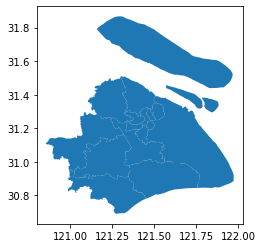

In [4]:
shapefile_crs_check(shp)

---

The world reference system (WRS) from NASA is a system to identify individual satellite imagery scenes using path-row tuples instead of absolute latitude/longitude coordinates. The latitudinal center of the image correpsonds to the row, the longitudinal center to the path. This system allows to uniformly catalogue satellite data across multiple missions and provides an easy to use reference system for the end user. It is necessary to note that the WRS was changed between Landsat missions, due to a difference in swath patterns of the more recent Landsat satellites (NASA, 2019). The WRS1 is used for Landsat missions 1-3 and the WRS2 for Landsat missons 4,5,7,8. 
In order to obtain path-row tuples of relevant satellite images for an area of interest (AOI), it is necessary to intersect the WRS shapefile (either WRS1 or WRS2, depending on the Landsat satellite you would like to obtain data from) with the AOI shapefile. The resulting path-row tuples will later be used to locate and download the corresponding satellite images from the Google Cloud Storage. The output of the intersection between WRS and AOI files can be visualised using an interactive widget. The map below shows our area of interest in purple and the footprints of the relevant Landsat images on top of an OpenStreetMap basemap.

---

In [5]:
# Donwload the WRS 2 file to later intersect the shapefile with the WRS path/row tuples to identify 
# relevant Landsat scenes
def sat_path():
    
    url = 'https://landsat.usgs.gov/sites/default/files/documents/WRS2_descending.zip'
    
    # Create folder for WRS2 file
    if os.path.exists(os.path.join(directory,'wrs2')):
        print('folder exists')
    else:
        os.makedirs(os.path.join(directory,'wrs2'))

    WRS_PATH = os.path.join(directory,'WRS2_descending.zip')
    LANDSAT_PATH = os.path.dirname(WRS_PATH)
    
    # The WRS file is only needed once thus we add this loop
    if os.path.exists(WRS_PATH):
        print('File already exists')
    # Downloads the WRS file from the URL given and unzips it
    else:
        wget.download(url, out = LANDSAT_PATH)
        shutil.unpack_archive(WRS_PATH, os.path.join(LANDSAT_PATH, 'wrs2'))

In [6]:
%%time
# WARNING: this will take time the first time it's executed
# depending on your connection
sat_path()

folder exists
File already exists
Wall time: 1.99 ms


In [7]:
# Intersect the shapefile with the WRS2 shapefile to determine relevant path/row tuples
def get_pathrow():
    global paths,rows,path,row, wrs_intersection
    
    wrs=gpd.GeoDataFrame.from_file(os.path.join(directory,'wrs2','WRS2_descending.shp'))
    wrs_intersection=wrs[wrs.intersects(bbox.geometry[0])]
    paths,rows=wrs_intersection['PATH'].values, wrs_intersection['ROW'].values
    
    for i, (path,row) in enumerate(zip(paths,rows)):
        print('Image', i+1, ' -path:', path, 'row:', row)

In [8]:
get_pathrow()

Image 1  -path: 118 row: 38
Image 2  -path: 119 row: 38


In [9]:
# Visualise the output of the intersection with the shapefile using Folium

# Get the center of the map
xy = np.asarray(bbox.centroid[0].xy).squeeze()
center = list(xy[::-1])

# Select a zoom
zoom = 8

# Create the most basic OSM folium map
m = folium.Map(location = center, zoom_start = zoom, control_scale=True)

# Add the bounding box (bbox) GeoDataFrame in red using a lambda function
m.add_child(folium.GeoJson(bbox.__geo_interface__, name = 'Area of Interest', 
                            style_function = lambda x: {'color': 'purple', 'alpha': 0}))


# Iterate through each polygon of paths and rows intersecting the area
for i, row in wrs_intersection.iterrows():
    # Create a string for the name containing the path and row of this Polygon
    name = 'path: %03d, row: %03d' % (row.PATH, row.ROW)
    # Create the folium geometry of this Polygon 
    g = folium.GeoJson(row.geometry.__geo_interface__, name=name)
    # Add a folium Popup object with the name string
    g.add_child(folium.Popup(name))
    # Add the object to the map
    g.add_to(m)
m

In [10]:
# Display number of images and Path/Row of the image
for i, (path,row) in enumerate(zip(paths,rows)):
    print('Image', i+1, ' -path:', path, 'row:', row)

Image 1  -path: 118 row: 38
Image 2  -path: 119 row: 38


Note that here you have two options: 1) continuing and executing the code reported in the next two sections on data donwload and image cropping, or 2) skipping these sections and proceeding to the image mosaicing sections. We recommend 2) as the processing of unzipping every folder may take long causing the JupyterLab instance to crash.

### Data download and pre-processing

We now have relevant path and row tuples for our area of analysis. So we can proceed to download satellite images, wich are stored on the Google Cloud. To download images, we specify certain parameters: time frame, cloudcover in percentage (0-100 %) and satellite mission (1-5,7,8). The here used Landsat578 API automatically searches the Google Cloud for scenes with the specified parameters and downloads matching images. In order to search the Google Cloud for relevant images, a list of available needs to be downloaded when the code is run for the first time. The list provides basic information of the satellite images and since Landsat data acquistion is ongoing, is updated continuously. Thus, if data from the latest aquistion data is required, it is recommended to re-download the file list before running the code.  

We use satellite imagery from Landsat 5 scene taken in 1984 and Landsat 8 taken in 2019 to determine neighbourhood changes over time. Landsat 5 scenes can be obtained from two different sensors, the Multispectral Scanner System and the Thematic Mapper, which provide 4 and 7 bands, respectively. The Multispectral Scanner System (MSS) is used in Landsat 1-3 and was superseded by the Thematic Mapper (TM). The MSS provides a green and red band (Band numbers: 1,2) and two infrared bands (Band numbers: 3,4), while the TM provides bands covering red,blue and green (Band numbers: 1,2,3), near-infrared (Band numbers: 4), short-wave infrared (Band numbers:5,7) and thermal infrared (6). Each downloaded scene contains all bands with one image per band. The different bands can then be stacked in order to highlight various Earth surface processes. 
In this exercise, scenes from the MSS and TM are downloaded, but only data from the TM is used for analysis.

The Operational Land Imager (OLI) aboard Landsat 8 provides multispectral bands (bands 1-7 and 9) with a resolution of 30 meters and a panchromatic band (band 8) with a resolution of 15 meters (Barsi et al., 2014a). The Thermal Infrared Sensor (TIRS) provides thermal infrared images (bands 10 and 11) with a resolution of 100 meters (Barsi et al., 2014b). The Landsat 8 satellite has a swath width of 185 km for the OLI and TIRS instruments, so one scene usually captures the extent of a city. In other cases, the geographical area of interest may extend beyond one image so that multiple images may be needed (Barsi et al., 2014b, Knight & Kvaran, 2014). Given the revisit time of 16 days, usually cloud free images can be retrieved for most cities on bi-weekly or monthly basis (Roy et al., 2014). The folder and filename of each scene provides information about the satellite, instrument, path/row tuple and date.

The tables below shows which general information of the downloaded scenes can be inferred from the folder and file names of each individual scene:

**FOLDER**:

LXPPPRRRYYYYDDDGSIVV

|Parameter|Meaning|
|---|---|
|L | Landsat|
|X | Sensor (“C”=OLI/TIRS combined, “O”=OLI-only, “T”=TIRS-only, “E”=ETM+, “T”=“TM, “M”=MSS)|
|PPP | WRS path|
|RRR | WRS row|
|YYYY | Year|
|DDD | Julian day of year|
|GSI | Ground station identifier|
|VV | Archive version number |

<br/><br/>

**IMAGE**:

LXSS_LLLL_PPPRRR_YYYYMMDD_yyyymmdd_CC_TX

|Parameter|Meaning|
|---|---|
| L | Landsat|
|X | Sensor (“C”=OLI/TIRS combined, “O”=OLI-only, “T”=TIRS-only, “E”=ETM+, “T”=“TM, “M”=MSS)|
|SS | Satellite (”07”=Landsat 7, “08”=Landsat 8)|
|LLL | Processing correction level (L1TP/L1GT/L1GS)|
|PPP | WRS path|
|RRR | WRS row|
|YYYYMMDD | Acquisition year, month, day|
|yyyymmdd | Processing year, month, day|
|CC | Collection number (01, 02, …)|
|TX | Collection category (“RT”=Real-Time, “T1”=Tier 1, “T2”=Tier 2)|

In [ ]:
# Download Tile list from Google - only needs to be done when first running the code
# NOTE this cell is using the ! magic, which runs command line processes from a Jupyter 
# notebook. Make sure the `landsat` tool, from the `landsat578` package is installed
# and available

#Path to index file
Index_PATH = os.path.join(directory + '/index.csv.gz')
if os.path.exists(Index_PATH):
    print('File already exists')
else:
    !landsat --update-scenes yes

In [ ]:
# Define Download function to acquire scenes from the Google API
def landsat_download(start_date, end_date, sat,path,row,cloud,output):
    g=GoogleDownload(start=start_date, end=end_date, satellite=sat, path=path, row=row, max_cloud_percent=cloud, output_path=output)
    g.download()

In [ ]:
# Specify start/end date (in YYYY-MM-DD format), the cloud coverage of the image (in %) and the satellite
# you would like to acquire images from (1-5,7,8). In this case we acquire a recent scene from Landsat 8
# with a cloud coverage of 5 %.

start_date = '2019-01-01'
end_date = '2019-02-20'
cloud = 5
satellites = [8]
output = os.path.join(directory + '/Landsat_images/')

In [ ]:
# Loop through the specified satellites for each path and row tuple
for sat in satellites:
    for i, (path,row) in enumerate(zip(paths,rows)):
        print('Image', i+1, ' -path:', path, 'row:', row)
        landsat_download(start_date, end_date,sat,path,row,cloud,output)

In [ ]:
# The above step is repeated to acquire a Landsat 5 scene from 1984 with 5 % cloud coverage. 
start_date = '1984-04-22'
end_date = '1984-04-24'
cloud = 5
satellites = [5]
output = os.path.join(directory + '/Landsat_images/')

In [ ]:
# Loop through the specified satellites for each path and row tuple
for sat in satellites:
    for i, (path,row) in enumerate(zip(paths,rows)):
        print('Image', i+1, ' -path:', path, 'row:', row)
        landsat_download(start_date, end_date,sat,path,row,cloud,output)

In [ ]:
# Delete Scenes that were acquired using the MSS:
outdir = os.listdir(output)
for i in outdir:
    if 'LM' in os.path.basename(i):
        try:
            shutil.rmtree(os.path.abspath(os.path.join(output,os.path.basename(i))))
        except OSError as e:
            print ("Error: %s - %s." % (e.filename, e.strerror))

#### Image Cropping

Satellite imagery is large. The size per image can easily equate to 1 GB. It often makes the data processing and  analysis computationally expensive. Cropping the obtained scenes to the relevant region of the image enables faster processing and analysing by significantly reducing the size of the input.

In [27]:
# Define cropping function using command line gdalwarp. 
## Note: The BQA band is the quality assessment band, which has a different no data value (1) than the other
## bands (0), which makes it necessary to us a different croping function. 

def crop(inraster,outraster,shape):
        !gdalwarp -cutline {shape} -srcnodata 0 -crop_to_cutline {inraster} {outraster}
        
def crop_bqa(inraster,outraster,shape):
        !gdalwarp -cutline {shape} -srcnodata 1 -crop_to_cutline {inraster} {outraster}

In [ ]:
# Loop through every folder and a create an image cropped to the extent of the shapefile
# save it with the original name and the extension _Cropped
for t in range(0,12):
    for filename in glob.glob((output+'/**/*_B{}.TIF').format(t), recursive=True):
        inraster = filename
        outraster = filename[:-4] + '_Cropped.TIF'    
        crop(inraster, outraster, shp)
for filename in glob.glob(output+'/**/*.TIF'):
    if 'BQA.TIF' in i:
        inraster = i
        outraster = i[:-4] + '_Cropped.TIF'    
        crop_bqa(inraster,outraster,shp)

#### Image mosaic

As indicated above, a single Landsat scene may not cover the full extent of a city due to the satellite's flight path as can be observed from the interactive map. Creating a mosaic of two or more images is thus often needed to produce a single image that covers the enterity of the area under analysis.

In [11]:
# Read in the relevant Landsat 8 files
output = 'Landsat_images/'
images = os.listdir(output)
dirpath1 = os.path.join(output, images[0])
dirpath2 = os.path.join(output, images[1])
mosaic_n = os.path.join(output,'Mosaic/')
search = 'L*_Cropped.TIF'
query1 = os.path.join(dirpath1,search)
query2 = os.path.join(dirpath2,search)
files1 =  glob.glob(query1)
files2 =  glob.glob(query2)
files1.sort()
files2.sort()
if os.path.exists(mosaic_n):
    print('Output Folder exists')
else:
    os.makedirs(mosaic_n)

In [12]:
# Match bands together and create a mosaic. Since the BQA band and the cloudmask have different denominations 
# than the other bands, these images have to be merged together separately. 
def mosaic_new(scene1,scene2): 
    src_mosaic =[]
    string_list=[]
    for i,j in zip(scene1,scene2):
        for k in range(1,12):
            string_list.append('B{}_Cropped'.format(k))
        for l in range(0,11):
            if string_list[l] in os.path.basename(i) and os.path.basename(j):
                src1 = rasterio.open(i)
                src2 = rasterio.open(j)
                src_mosaic = [src1,src2] 
                mosaic,out_trans = rasterio.merge.merge(src_mosaic)
                out_meta = src1.meta.copy()
                out_meta.update({"driver": "GTiff", 'height':mosaic.shape[1],'width':mosaic.shape[2],
                                'transform':out_trans})
                outdata = os.path.join(mosaic_n,'B{}_mosaic.tif'.format(l))
                with rasterio.open(outdata,'w',**out_meta) as dest:
                    dest.write(mosaic)
        # Mosaic Quality Assessment Band           
        if 'BQA_Cropped' in os.path.basename(i) and os.path.basename(j):
            bqa1 = rasterio.open(i)
            bqa2 = rasterio.open(j)
            bqa_mosaic = [bqa1,bqa2] 
            mosaic_,out_trans = rasterio.merge.merge(bqa_mosaic,nodata=1)
            out_meta = bqa1.meta.copy()
            out_meta.update({"driver": "GTiff", 'height':mosaic_.shape[1],'width':mosaic_.shape[2],
                            'transform':out_trans})
            outdata = os.path.join(mosaic_n,'BQA_mosaic.tif')
            with rasterio.open(outdata,'w',**out_meta) as dest:
                dest.write(mosaic_)

            # Mosaic of Cloudmask   
            search = 'cloudmask.TIF'
            query3 = os.path.join(dirpath1,search)
            query4 = os.path.join(dirpath2,search)    
            files3 =  glob.glob(query3)
            files4 =  glob.glob(query4)
            for i,j in zip(files3,files4):
                if 'cloudmask' in os.path.basename(i)and os.path.basename(j):
                    cloudmask1 = rasterio.open(i)
                    cloudmask2 = rasterio.open(j)
                    cloud_mosaic = [cloudmask1,cloudmask2] 
                    mosaic_c,out_trans = rasterio.merge.merge(cloud_mosaic,nodata=1)
                    out_meta = cloudmask1.meta.copy()
                    out_meta.update({"driver": "GTiff", 'height':mosaic_c.shape[1],'width':mosaic_c.shape[2],
                                    'transform':out_trans})
                    outdata = os.path.join(mosaic_n,'Cloudmask_mosaic.tif')
                    with rasterio.open(outdata,'w',**out_meta) as dest:
                        dest.write(mosaic_c)


In [13]:
mosaic_new(files1,files2)

In [14]:
# Read in the relevant files for the Landsat 5 scenes
images = os.listdir(output)
dirpath_o1 = os.path.join(output, images[2])
dirpath_o2 = os.path.join(output, images[3])
mosaic_o = os.path.join(output,'Mosaic_old/')
query_o1 = os.path.join(dirpath_o1,search)
query_o2 = os.path.join(dirpath_o2,search)
files_o1 =  glob.glob(query_o1)
files_o2 =  glob.glob(query_o2)
files_o1.sort()
files_o2.sort()
if os.path.exists(mosaic_o):
    print('Output Folder exists')
else:
    os.makedirs(mosaic_o)

In [15]:
# Match bands together and create a mosaic. Since the BQA band and the cloudmask have different denominations 
# than the other bands, these images have to be merged together separately. 
def mosaic_old(scene_o1,scene_o2):
    src_mosaic =[]
    string_list=[]
    for i,j in zip (scene_o1,scene_o2):

        for k in range(1,8):
            string_list.append('B{}_Cropped'.format(k))
        for l in range(0,7):
            if string_list[l] in os.path.basename(i) and os.path.basename(j):
                src1 = rasterio.open(i)
                src2 = rasterio.open(j)
                src_mosaic = [src1,src2] 
                mosaic,out_trans= rasterio.merge.merge(src_mosaic)
                out_meta = src1.meta.copy()
                out_meta.update({"driver": "GTiff", 'height':mosaic.shape[1],'width':mosaic.shape[2],
                                'transform':out_trans})
                outdata = os.path.join(mosaic_o,'B{}_mosaic.tif'.format(l))
                with rasterio.open(outdata,'w',**out_meta) as dest:
                    dest.write(mosaic)
        # Mosaic Quality Assessment Band           
        if 'BQA_Cropped' in os.path.basename(i) and os.path.basename(j):
            bqa1 = rasterio.open(i)
            bqa2 = rasterio.open(j)
            bqa_mosaic = [bqa1,bqa2] 
            mosaic_,out_trans= rasterio.merge.merge(bqa_mosaic,nodata=1)
            out_meta = bqa1.meta.copy()
            out_meta.update({"driver": "GTiff", 'height':mosaic_.shape[1],'width':mosaic_.shape[2],
                            'transform':out_trans})
            outdata = os.path.join(mosaic_o,'BQA_mosaic.tif')
            with rasterio.open(outdata,'w',**out_meta) as dest:
                dest.write(mosaic_)

            # Mosaic of Cloudmask   
            search = 'cloudmask.TIF'
            query_o3= os.path.join(dirpath_o1,search)
            query_o4 = os.path.join(dirpath_o2,search)    
            files_o3 =  glob.glob(query_o3)
            files_o4 =  glob.glob(query_o4)
            for i,j in zip(files_o3,files_o4):
                if 'cloudmask' in os.path.basename(i)and os.path.basename(j):
                    cloudmask1 = rasterio.open(i)
                    cloudmask2 = rasterio.open(j)
                    cloud_mosaic = [cloudmask1,cloudmask2] 
                    mosaic_c,out_trans= rasterio.merge.merge(cloud_mosaic,nodata=1)
                    out_meta = cloudmask1.meta.copy()
                    out_meta.update({"driver": "GTiff", 'height':mosaic_c.shape[1],'width':mosaic_c.shape[2],
                                    'transform':out_trans})
                    outdata = os.path.join(mosaic_o,'Cloudmask_mosaic.tif')
                    with rasterio.open(outdata,'w',**out_meta) as dest:
                        dest.write(mosaic_c)

In [16]:
mosaic_old(files_o1,files_o2)

### Natural-colour (True-colour) composition 

Our downloaded data from Landsat 8 and Landsat 5 have different band designations. Combining different satellite bands are useful to identify features of the urban environment: vegetation, built up areas, ice and water. We create a standard natural-colour composition image using Red, Green and Blue satellite bands. This colour composition best reflects the natural environment. For instance, trees are green; snow and clouds are white; and, water is blue. Landsat 8 has 11 bands with bands 4, 3 and 2 corresponding to Red, Green and Blue respectively. Landsat 5 has 7 bands with bands 3, 2 and 1, corresponding to Red, Green and Blue. We perform layer stacking to produce a true colour image composition to gain understanding of the local area before extracting and analying features of the urban environment. 

In [17]:
# Use rasterio to open the Red, Blue and Green bands of the mosaic image from 1984 to create an RGB image
# **NOTE**: The Mosaic names do not correspond to the actual band designations as python starts
# counting at 0!
b1_old=rasterio.open('Landsat_images/Mosaic_old/B0_mosaic.tif')
b2_old=rasterio.open('Landsat_images/Mosaic_old/B1_mosaic.tif')
b3_old=rasterio.open('Landsat_images/Mosaic_old/B2_mosaic.tif')

In [18]:
# Normalise the bands to so that they can be combined to a single image
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))


In [19]:
# Adjust the intensity of each band for visualisation.
# This is a way of rescaling each band by clipping the pixels that are outside the specified range to
# the range we defined. By adjusting the gamma, we change the brightness of the image with gamma >1 
# reuslting in a brighter image. However there are more complex methods such as top of the atmosphere 
# corrections, which subtracts any atmospheric interference from the image. 
# For the purpose of this notebook, this way is sufficient. 
def rescale_intensity(image):
    p2, p98 = np.percentile(image, (0.2, 98))
    img_exp = exposure.rescale_intensity(image, in_range=(p2, p98)) 
    img_gamma = exposure.adjust_gamma(img_exp, gamma=2.5,gain=1)
    return(img_gamma)

In [20]:
# Downsample image resolution with factor 0.5 for displaying purposes.
def downsample(file):
    downscale_factor=0.5
    data = file.read(1,
        out_shape=(
            file.count,
            int(file.height * downscale_factor),
            int(file.width * downscale_factor)
        ),
        resampling=Resampling.bilinear
    )
    # scale image transform
    transform = file.transform * file.transform.scale(
        (file.width / data.shape[-1]),
        (file.height / data.shape[-2])
    )
    return data

In [21]:
with rasterio.open('Landsat_images/Mosaic_old/B0_mosaic.tif') as band1_old:
    b1_old=downsample(band1_old)
with rasterio.open('Landsat_images/Mosaic_old/B1_mosaic.tif') as band2_old:
    b2_old=downsample(band2_old)
with rasterio.open('Landsat_images/Mosaic_old/B2_mosaic.tif') as band3_old:
    b3_old=downsample(band3_old)

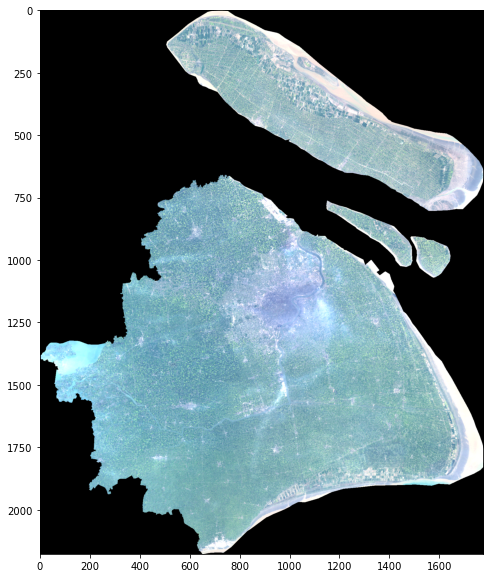

In [22]:
# Normalise the bands so that they can be combined to a single image
red_old_n = normalize(b3_old)
green_old_n = normalize(b2_old)
blue_old_n = normalize(b1_old)

# Apply the function defined before to make more natural-looking image
red_adj = rescale_intensity(red_old_n)
green_adj = rescale_intensity(green_old_n)
blue_adj = rescale_intensity(blue_old_n)

# Stack the three different bands together
rgb_2 = np.dstack((red_adj,green_adj,blue_adj))

# Visualise the true color image
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(rgb_2)
plt.show()
plt.close()

In [23]:
# Use rasterio to open the Red, Blue and Green bands of the mosaic image from 2019 to create an RGB image
# **NOTE**: The Mosaic names do not correspond to the actual band designations as python starts
# counting at 0!!
with rasterio.open('Landsat_images/Mosaic/B1_mosaic.tif') as band2_new:
    b2_new = downsample(band2_new)
with rasterio.open('Landsat_images/Mosaic/B2_mosaic.tif') as band3_new:
    b3_new = downsample(band3_new)
with rasterio.open('Landsat_images/Mosaic/B3_mosaic.tif') as band4_new:   
    b4_new = downsample(band4_new)

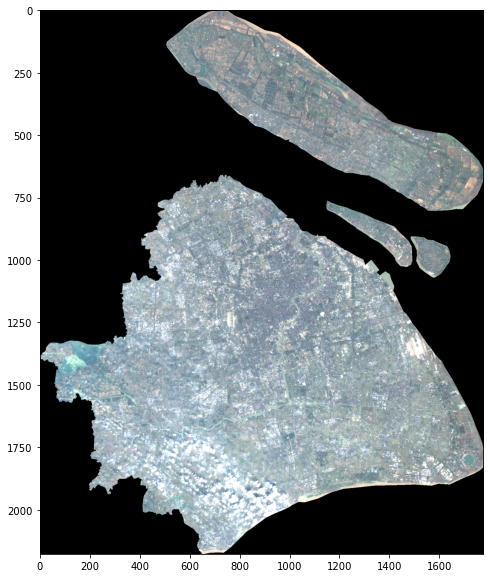

In [24]:
# Normalise the bands so that they can be combined to a single image
red_new_n = normalize(b4_new)
green_new_n = normalize(b3_new)
blue_new_n = normalize(b2_new)

# Apply the function defined before to make more natural-looking image
red_rescale = rescale_intensity(red_new_n)
green_rescale = rescale_intensity(green_new_n)
blue_rescale = rescale_intensity(blue_new_n)

# Stack the three different bands together
rgb = np.dstack((red_rescale, green_rescale, blue_rescale))

# Here we adjust the gamma (brightness) for the stacked image to achieve a more natural looking image. 
rgb_adjust = exposure.adjust_gamma(rgb, gamma = 1.5, gain=1)

# Visualise the true color image
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(rgb_adjust)
plt.show()
plt.close()

### Feature extraction
To identify changes in urban neighbourhood over time, various features of the urban environment can be extracted and analysed. We examine four sets of features: colour and texture features from true colour imagery (i.e. RGB bands composition), and vegetation features and built-up features from Red, near infrared (NIR) and shortwave infrared (SWIR) bands. In this analysis, colour features measure the colour moments of ture colour imagery to interpret colour distribution; texture features apply LBP (Local binary patterns) texture spectrum model to show spatial distribution of intensity values in an image; vegetation features calculate the NDVI (Normalised difference vegetation index) to capture the amount of vegetation, and built-up features caculate NDBI (Normalised difference built-up index) to highlight artifically constructed areas. 

The administritive divisions of Shanghai have experienced tremendous changes in the last tens of years (MCAPRC, 2018), thus, we will conduct feature extration of imagery on the current administritive boundaries to explore if satellite imagery can be used to reflect and interpret urban changes. The figure below shows the spatial distribution and name of these areas.

Text(0.5, 0.98, 'Administritive divisions of Shanghai')

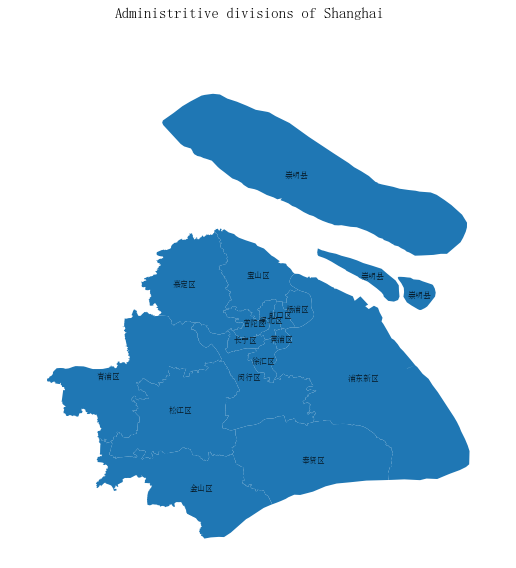

In [25]:
#read administritive boundary shapefile of Shanghai 
poly = gpd.read_file(shp)

#add class labels to the left of each raw, install 'SimSun' on your system to render Mandarin in matplotlib
import matplotlib as mpl
font_name = "SimSun"
mpl.rcParams['font.family']= font_name

f, ax = plt.subplots(1, figsize = (9,9))
poly.plot(ax = ax)
#create a new colomn for inner_london, in order to plot polygon labels (i.e. name) in the map
poly['coords']=poly['geometry'].apply(lambda x:x.representative_point().coords[:])
poly['coords']=[coords[0] for coords in poly['coords']]
for idx, row in poly.iterrows():
    ax.annotate(s=row['Name'],xy=row['coords'],va='center',ha='center',alpha = 0.8, fontsize = 8)
plt.axis('equal')
plt.axis('off')
f.suptitle('Administritive divisions of Shanghai', fontsize = 15)

In [26]:
poly.loc[poly['Name']== '崇明县']

,OID_,Name,FolderPath,SymbolID,AltMode,Base,Clamped,Extruded,Snippet,PopupInfo,Shape_Leng,Shape_Area,geometry,coords
0,0,崇明县,区县/区县,0,0,0.0,-1,0,None,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",1.921339,0.133777,"POLYGON Z ((121.24055 31.71320 0.00000, 121.24...","(121.51489159858086, 31.654863000000034)"
3,0,崇明县,区县/区县,0,0,0.0,-1,0,None,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",0.552764,0.009068,"POLYGON Z ((121.77366 31.31691 0.00000, 121.75...","(121.7157753452659, 31.38690150000005)"
5,0,崇明县,区县/区县,0,0,0.0,-1,0,None,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",0.298602,0.005598,"POLYGON Z ((121.84247 31.29451 0.00000, 121.83...","(121.84187767409576, 31.33721550000007)"


The above map and table show that three geometries have identical administrative names that may confuse the analysis result. As a result, we dissolved these geometries into a single geoemetric feature.   

In [27]:
#Dissolve geometries with the identical names together
poly = poly.dissolve(by = 'Name').reset_index()
poly

,Name,geometry,OID_,FolderPath,SymbolID,AltMode,Base,Clamped,Extruded,Snippet,PopupInfo,Shape_Leng,Shape_Area,coords
0,嘉定区,"POLYGON Z ((121.29753 31.50113 0.00000, 121.29...",0,区县/区县,2,0,0.0,-1,0,NaN,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",1.556168,0.043242,"(121.21932638424533, 31.365654500000062)"
1,奉贤区,"POLYGON Z ((121.35276 30.97814 0.00000, 121.36...",0,区县/区县,4,0,0.0,-1,0,NaN,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",1.318697,0.067998,"(121.56065980897392, 30.89682200000007)"
2,宝山区,"POLYGON Z ((121.29753 31.50113 0.00000, 121.29...",0,区县/区县,1,0,0.0,-1,0,NaN,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",1.141426,0.027744,"(121.4139260994209, 31.388573500000064)"
3,崇明县,"MULTIPOLYGON Z (((121.24055 31.71320 0.00000, ...",0,区县/区县,0,0,0.0,-1,0,NaN,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",1.921339,0.133777,"(121.51489159858086, 31.654863000000034)"
4,徐汇区,"POLYGON Z ((121.43260 31.21555 0.00000, 121.43...",0,区县/区县,2,0,0.0,-1,0,NaN,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",0.420446,0.005182,"(121.42953006192042, 31.161066000000062)"
5,普陀区,"POLYGON Z ((121.33108 31.29734 0.00000, 121.33...",0,区县/区县,3,0,0.0,-1,0,NaN,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",0.571248,0.005187,"(121.40409891079028, 31.26242400000004)"
6,杨浦区,"POLYGON Z ((121.51853 31.34896 0.00000, 121.52...",0,区县/区县,0,0,0.0,-1,0,NaN,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",0.335590,0.005733,"(121.51869469927166, 31.298531000000054)"
7,松江区,"POLYGON Z ((121.26144 31.13817 0.00000, 121.26...",0,区县/区县,3,0,0.0,-1,0,NaN,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",1.998624,0.057151,"(121.20967168436368, 31.02867150000003)"
8,浦东新区,"POLYGON Z ((121.83028 31.14789 0.00000, 121.80...",0,区县/区县,3,0,0.0,-1,0,NaN,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",1.597617,0.054323,"(121.69360621884246, 31.117209500000058)"
9,虹口区,"POLYGON Z ((121.46171 31.31811 0.00000, 121.46...",0,区县/区县,4,0,0.0,-1,0,NaN,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",0.241918,0.002211,"(121.47207625707068, 31.28110650000005)"


#### Image processing
Further pre-processing of satellite imagery is needed before feature extraction. This pre-processing involves three steps: 
* Masking(cropping) of raster files (i.e., Blue, Green, Red, Nir and SWIR bands) into each administrative district polygon;
* Image enhancement to improve the quality and content of the original image; and,
* Band stacking based on each neighbourhood unit.

In [28]:
#open raster files
file_list_old = glob.glob(mosaic_o + "/*.TIF")
files_old = [rio.open(filename) for filename in file_list_old]

In [29]:
file_list = glob.glob(mosaic_n + "/*.TIF")
files = [rio.open(filename) for filename in file_list]

Before cropping all raster files into each polygon in the vector file (i.e. Shanghai administrative area shapefile), we have to ensure they have the same coordinate reference system (CRS). Once matched, the cropping process is prepared to go.

In [30]:
poly.crs

{'init': 'epsg:4326'}

In [31]:
#check one band of satellite imagery
files[0].crs

CRS.from_epsg(32651)

In [32]:
#reproject the vector file to make it consistent with raster files
poly = poly.to_crs(epsg = 32651)
poly.crs

c:\users\meixu\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


{'init': 'epsg:32651', 'no_defs': True}

In [33]:
poly.head()

,Name,geometry,OID_,FolderPath,SymbolID,AltMode,Base,Clamped,Extruded,Snippet,PopupInfo,Shape_Leng,Shape_Area,coords
0,嘉定区,"POLYGON Z ((338316.681 3486397.369 0.000, 3383...",0,区县/区县,2,0,0.0,-1,0,NaN,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",1.556168,0.043242,"(121.21932638424533, 31.365654500000062)"
1,奉贤区,"POLYGON Z ((342698.745 3428343.578 0.000, 3439...",0,区县/区县,4,0,0.0,-1,0,NaN,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",1.318697,0.067998,"(121.56065980897392, 30.89682200000007)"
2,宝山区,"POLYGON Z ((338316.681 3486397.369 0.000, 3382...",0,区县/区县,1,0,0.0,-1,0,NaN,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",1.141426,0.027744,"(121.4139260994209, 31.388573500000064)"
3,崇明县,MULTIPOLYGON Z (((333283.317 3509992.433 0.000...,0,区县/区县,0,0,0.0,-1,0,NaN,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",1.921339,0.133777,"(121.51489159858086, 31.654863000000034)"
4,徐汇区,"POLYGON Z ((350694.976 3454549.695 0.000, 3507...",0,区县/区县,2,0,0.0,-1,0,NaN,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",0.420446,0.005182,"(121.42953006192042, 31.161066000000062)"


In [34]:
#get each neighbourhood geographic boundary based on administritive area data
geo = [poly.__geo_interface__['features'][i]['geometry'] 
            for i in range(len(poly))]

In [35]:
#clip R,G,B bands separately by each poly, so get pixel values in each poly and save them into a list
out_image = [[] for i in range(5)]
img_old = [[] for i in range(5)]

for x in range(5):#Blue,Green,Red,NIR and SWIR bands
    for y in range(len(geo)):#16 polygons
        #out_image[0] means masked Blue band polygon
        out_image[x].append(mask(files_old[0:5][x], [geo[y]], crop=True))
        #image enhancement: normalisation and Histogram Equalization
        img_old[x].append(exposure.equalize_hist(normalize(out_image[x][y][0][0])))

In [36]:
#clip R,G,B bands separately by each poly, so get pixel values in each poly and save them into a list
out_image = [[] for i in range(5)]
img_new = [[] for i in range(5)]

for x in range(5):#Blue,Green,Red,NIR and SWIR bands
    for y in range(len(geo)):#16 polygons
        #out_image[0] means masked Blue band polygon
        out_image[x].append(mask(files[2:7][x], [geo[y]], crop=True))
        #image enhancement: normalisation and Histogram Equalization
        img_new[x].append(exposure.equalize_hist(normalize(out_image[x][y][0][0])))

In [37]:
#have a look at the pixel values of one geographic area in blue band
img_new[0][0]

array([[0.41411516, 0.41411516, 0.41411516, ..., 0.41411516, 0.41411516,
        0.41411516],
       [0.41411516, 0.41411516, 0.41411516, ..., 0.41411516, 0.41411516,
        0.41411516],
       [0.41411516, 0.41411516, 0.41411516, ..., 0.41411516, 0.41411516,
        0.41411516],
       ...,
       [0.41411516, 0.41411516, 0.41411516, ..., 0.41411516, 0.41411516,
        0.41411516],
       [0.41411516, 0.41411516, 0.41411516, ..., 0.41411516, 0.41411516,
        0.41411516],
       [0.41411516, 0.41411516, 0.41411516, ..., 0.41411516, 0.41411516,
        0.41411516]])

In [38]:
#stack R,G,B bands of each administritive boundary 
rgb_old = []
for i in range(len(geo)):
    # converte array to float
    bb = img_old[0][i].astype(np.float)
    bg = img_old[1][i].astype(np.float)
    br = img_old[2][i].astype(np.float)
    # Create RGB
    rgb_old.append( np.dstack((br,bg,bb)) )

In [39]:
rgb_new = []
for i in range(len(geo)):
    # converte array to float
    bb = img_new[0][i].astype(np.float)
    bg = img_new[1][i].astype(np.float)
    br = img_new[2][i].astype(np.float)
    # Create RGB
    rgb_new.append( np.dstack((br,bg,bb)) )

#### Colour features
Colour features correspond to the colour moments of an image. These features provide a measurement of colour similiarity between images (Keen, 2005). Basically, colour probability distribution of an image are characterised by a range of unique moments. The mean, standard deviation and skewness these three central moments are generally used to identify colour distribution.  Here we extract colour features on HSV (Hue, Saturation and Value) colour space because it corresponds to human vision and has been widely used in computer vision. HSV colour space can be converted from RGB colour channels, Hue represents the colour portion, saturation represents the amount of gray in a particular colour (0 is gray), and Value represents the brightness of the colour (0 is black). Therefore, the true-colour imagery is characterised by a total of nine moments - three moments for each HSV channel in the same units.

In [40]:
#interpret the color probability distribution by computing low order color moments(1,2,3)
def color_moments(img):
    if img is None:
        return
    # Convert RGB to HSV colour space
    img_hsv = rgb2hsv(img)
    # Split the channels - h,s,v
    h, s, v = [img_hsv[:,:,i] for i in [0,1,2]]
    # Initialize the colour feature
    color_feature = []
    # N = h.shape[0] * h.shape[1]
    # The first central moment - average 
    h_mean = np.mean(h)  # np.sum(h)/float(N)
    s_mean = np.mean(s)  # np.sum(s)/float(N)
    v_mean = np.mean(v)  # np.sum(v)/float(N)
    color_feature.extend([h_mean, s_mean, v_mean])
    # The second central moment - standard deviation
    h_std = np.std(h)  # np.sqrt(np.mean(abs(h - h.mean())**2))
    s_std = np.std(s)  # np.sqrt(np.mean(abs(s - s.mean())**2))
    v_std = np.std(v)  # np.sqrt(np.mean(abs(v - v.mean())**2))
    color_feature.extend([h_std, s_std, v_std])
    # The third central moment - the third root of the skewness
    h_skewness = np.mean(abs(h - h.mean())**3)
    s_skewness = np.mean(abs(s - s.mean())**3)
    v_skewness = np.mean(abs(v - v.mean())**3)
    h_thirdMoment = h_skewness**(1./3)
    s_thirdMoment = s_skewness**(1./3)
    v_thirdMoment = v_skewness**(1./3)
    color_feature.extend([h_thirdMoment, s_thirdMoment, v_thirdMoment])

    return color_feature

In [41]:
#create and initialize a data table to store colour feastures
color_mom_old = pd.DataFrame(color_moments(rgb_old[0]))
#add the rest columns by assigning 9 color moments in each poly
for i in range(1,len(rgb_old)):
    color_mom_old[i]= color_moments(rgb_old[i])
    i = i+1

In [42]:
#create and initialize a data table
color_mom_new = pd.DataFrame(color_moments(rgb_new[0]))
#add the rest columns by assigning 9 color moments in each poly
for i in range(1,len(rgb_new)):
    color_mom_new[i]= color_moments(rgb_new[i])
    i = i+1

In [43]:
#Data manipulation
color_old_var = color_mom_old.T
#assign column names
color_old_var.columns = ['h_mean','s_mean','v_mean','h_std','s_std','v_std','h_skew','s_skew','v_skew']
#set geographic name as index
color_old_var= color_old_var.set_index(poly.Name)

In [44]:
color_new_var = color_mom_new.T
color_new_var.columns = ['h_mean','s_mean','v_mean','h_std','s_std','v_std','h_skew','s_skew','v_skew']
color_new_var= color_new_var.set_index(poly.Name)

In [45]:
#check the information of colour feature table and the first 5 lines 
color_old_var.info()
color_old_var.head()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 嘉定区 to 黄浦区
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   h_mean  16 non-null     float64
 1   s_mean  16 non-null     float64
 2   v_mean  16 non-null     float64
 3   h_std   16 non-null     float64
 4   s_std   16 non-null     float64
 5   v_std   16 non-null     float64
 6   h_skew  16 non-null     float64
 7   s_skew  16 non-null     float64
 8   v_skew  16 non-null     float64
dtypes: float64(9)
memory usage: 1.2+ KB


,h_mean,s_mean,v_mean,h_std,s_std,v_std,h_skew,s_skew,v_skew
Name,,,,,,,,,
嘉定区,0.301181,0.081444,0.626403,0.322999,0.094840,0.216332,0.348328,0.112093,0.229704
奉贤区,0.339613,0.112915,0.605758,0.321941,0.122805,0.243621,0.347226,0.144392,0.257670
宝山区,0.272161,0.052081,0.644148,0.327094,0.072457,0.185309,0.356713,0.090057,0.199446
崇明县,0.153807,0.017394,0.742309,0.272162,0.035627,0.102347,0.332916,0.051184,0.120603
徐汇区,0.229198,0.059622,0.654821,0.295229,0.086698,0.182244,0.334225,0.108904,0.194645


In [46]:
color_new_var.info()
color_new_var.head()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 嘉定区 to 黄浦区
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   h_mean  16 non-null     float64
 1   s_mean  16 non-null     float64
 2   v_mean  16 non-null     float64
 3   h_std   16 non-null     float64
 4   s_std   16 non-null     float64
 5   v_std   16 non-null     float64
 6   h_skew  16 non-null     float64
 7   s_skew  16 non-null     float64
 8   v_skew  16 non-null     float64
dtypes: float64(9)
memory usage: 1.2+ KB


,h_mean,s_mean,v_mean,h_std,s_std,v_std,h_skew,s_skew,v_skew
Name,,,,,,,,,
嘉定区,0.252007,0.054752,0.614861,0.298679,0.070628,0.208581,0.332144,0.086960,0.222700
奉贤区,0.295539,0.086197,0.605431,0.302731,0.097695,0.243596,0.329388,0.115702,0.257234
宝山区,0.231070,0.035865,0.638941,0.297847,0.052048,0.180189,0.336779,0.067866,0.195591
崇明县,0.157306,0.016473,0.742402,0.282495,0.031843,0.101771,0.345289,0.043360,0.119800
徐汇区,0.235546,0.032214,0.642975,0.304516,0.048830,0.174089,0.342597,0.063170,0.189419


#### Texture features

To extract texture features, we use a Local Binary Pattern (LBP) approach. LBP searches for pixels adjacent to a central point and tests whether these surrounding pixels are greater or less than the central pixel and generate a binary classification ([Pedregosa et al., 2011](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html)). In theory, eight adjacent neighbour pixels in grayscale are set to compare with one central pixel value by 3 * 3 neighbourhood threshold, and consider the result as 1 or 0 (Ojala et al., 1996). Thus, these eight surrounding binary numbers correspond to LBP code for the central pixel value, determining the texture pattern of that threshold. Texture features are then the distribution of a collection of LBPs over an image.

In [48]:
#convert a RGB image into Grayscale,which takes less space for analysis
gray_images_old = [rgb2gray(rgb_old[i]) for i in range(len(rgb_old))]
gray_images_new = [rgb2gray(rgb_new[i]) for i in range(len(rgb_new))]

In [49]:
# settings for LBP
radius = 1 #radius = 1 refers to a 3*3 patch/window scale
n_points = 8 * radius # the number of circularly symmetric neighbour set points 
method = 'uniform'#finer quantization of the angular space which is gray scale and rotation invariant

lbps_old = [local_binary_pattern(gray_images_old[i],n_points,radius,method) for i in range(len(rgb_old))]
lbps_new = [local_binary_pattern(gray_images_new[i],n_points,radius,method) for i in range(len(rgb_new))]


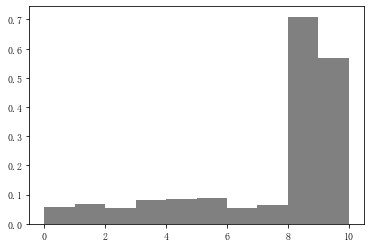

In [50]:
#n_bins are the same in each neighbourhood
n_bins = int(lbps_old[0].max()+1)

#plot histogram of LBP distribution
hist_features_old = []#return counts

for i in range(len(rgb_old)):
    counts,bins,patches = plt.hist(lbps_old[i].ravel(), density=True, bins=n_bins, \
                                 range=(0, n_bins),facecolor='0.5')
    hist_features_old.append(counts)#return the higtogram vector features in this cell(polygon)

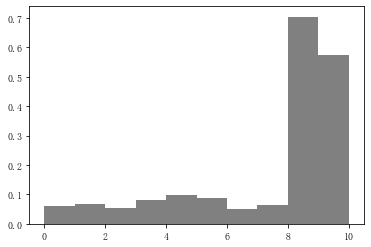

In [51]:
#n_bins are the same in each neighbourhood
n_bins = int(lbps_new[0].max()+1)

#plot histogram of LBP distribution
hist_features_new = []#return counts

for i in range(len(rgb_new)):
    counts,bins,patches = plt.hist(lbps_new[i].ravel(), density=True, bins=n_bins, \
                                 range=(0, n_bins),facecolor='0.5')
    hist_features_new.append(counts)#return the higtogram vector features in this cell(polygon)

In [52]:
#The histogram features are the texture features
texture_old_var = pd.DataFrame([hist_features_old[a] for a in range(len(rgb_old))])
texture_old_var.columns = ['LBP'+ str(i) for i in range(n_bins)]
texture_old_var = texture_old_var.set_index(poly.Name)
texture_old_var.head()

,LBP0,LBP1,LBP2,LBP3,LBP4,LBP5,LBP6,LBP7,LBP8,LBP9
Name,,,,,,,,,,
嘉定区,0.040539,0.049634,0.047729,0.079348,0.081188,0.070370,0.044872,0.048862,0.458657,0.078801
奉贤区,0.055508,0.066468,0.051230,0.072002,0.073767,0.073928,0.052907,0.065099,0.382110,0.106981
宝山区,0.035093,0.041960,0.040705,0.068394,0.078389,0.067483,0.040339,0.041101,0.520053,0.066483
崇明县,0.025822,0.029946,0.021757,0.034058,0.039580,0.036787,0.024035,0.029158,0.709444,0.049413
徐汇区,0.038551,0.046536,0.043095,0.062896,0.059936,0.066354,0.039247,0.044363,0.526531,0.072491


In [53]:
#The histogram features are the texture features
texture_new_var = pd.DataFrame([hist_features_new[a] for a in range(len(rgb_new))])
texture_new_var.columns = ['LBP'+ str(i) for i in range(n_bins)]
texture_new_var = texture_new_var.set_index(poly.Name)
texture_new_var.head()

,LBP0,LBP1,LBP2,LBP3,LBP4,LBP5,LBP6,LBP7,LBP8,LBP9
Name,,,,,,,,,,
嘉定区,0.046763,0.052593,0.046684,0.069190,0.081320,0.067009,0.043335,0.051532,0.457167,0.084407
奉贤区,0.051206,0.061050,0.052882,0.081410,0.097157,0.079233,0.051521,0.060437,0.369931,0.095174
宝山区,0.043059,0.047740,0.040768,0.058617,0.068075,0.056809,0.037410,0.045565,0.524189,0.077767
崇明县,0.025468,0.029637,0.023332,0.035217,0.047621,0.036412,0.023590,0.028650,0.704424,0.045649
徐汇区,0.045433,0.048966,0.041469,0.054248,0.056785,0.060633,0.037630,0.046693,0.527684,0.080459


### Vegetation and built-up features

Vegetation features and built-up features can be measured by calculating NDVI and NDBI index in each administritive area repectively. The Normalized Difference Vegetation Index (NDVI) is a normalized index, using Red and NIR bands to display the amount of vegetation (NASA, 2000). The use of NDVI maximizes the reflectance properties of vegetation by minimizing NIR and maximizing the reflectance in the red wavelength. The formula is as follows:

                  NDVI = (NIR - Red)/(NIR + Red)
The output value of this index is between -1.0 and 1.0. Close to 0 represents no vegatation, close to 1 indicates the highest possible density of green leaves, and close to -1 indicates water bodies. 

The Normalized Difference Built-up Index (NDBI) uses the NIR and SWIR bands to highlight artificially constructed areas (Zha et al., 2003). The index is a ratio type that reduces the effects of differences in terrain illumination and atmospheric effects. The formula is as follows:

                 NDBI = (SWIR - NIR) / (SWIR + NIR)
Also, the output value of this index is between -1 to 1. Higher values represent built-up areas whereas negative value represent water bodies.

After calculating these two indices, vegatation features and built-up features can be measured by calculating average values of index values within each administritive area.

* Vegatation features

In [54]:
#identify red and NIR band to each neighbourhood unit in 1984
red_old, nir_old = img_old[2],img_old[3]
# Calculate ndvi, assign 0 to nodata pixels
ndvi_old = [np.where((nir_old[i] + red_old[i])==0, 0, 
                    (nir_old[i]-red_old[i])/(nir_old[i] + red_old[i])) 
            for i in range(len(poly))]

In [55]:
#identify red and NIR band to each neighbourhood unit in 1984
red_new, nir_new = img_new[2],img_new[3]
# Calculate ndvi, assign 0 to nodata pixels
ndvi_new = [np.where((nir_new[i] + red_new[i])==0, 0, 
                    (nir_new[i]-red_new[i])/(nir_new[i] + red_new[i])) 
            for i in range(len(poly))]

In [56]:
veg_old_var = pd.DataFrame([np.mean(ndvi_old[i]) for i in range(len(poly))], 
                       index = poly.Name, columns = ['veg_mean'])
veg_old_var.head()

,veg_mean
Name,
嘉定区,-0.004255
奉贤区,-0.007201
宝山区,-0.002218
崇明县,-0.000805
徐汇区,-0.003281


In [57]:
veg_new_var = pd.DataFrame([np.mean(ndvi_new[i]) for i in range(len(poly))], 
                       index = poly.Name, columns = ['veg_mean'])
veg_new_var.head()

,veg_mean
Name,
嘉定区,-0.002070
奉贤区,-0.008185
宝山区,-0.001801
崇明县,-0.000705
徐汇区,-0.001966


* Built-up features

In [58]:
#identify red and NIR band to each neighbourhood unit in 1984
nir_old, swir_old = img_old[3],img_old[4]
# Calculate ndvi, assign 0 to nodata pixels
ndbi_old = [np.where((nir_old[i] + swir_old[i])==0., 0, 
                    (swir_old[i] - nir_old[i])/(nir_old[i] + swir_old[i])) 
            for i in range(len(poly))]

In [59]:
#identify red and NIR band to each neighbourhood unit in 1984
nir_new, swir_new = img_new[3],img_new[4]
# Calculate ndvi, assign 0 to nodata pixels
ndbi_new = [np.where((nir_new[i] + swir_new[i])==0., 0, 
                    (swir_new[i] - nir_new[i])/(nir_new[i] + swir_new[i])) 
            for i in range(len(poly))]

In [60]:
builtup_old_var = pd.DataFrame([np.mean(ndbi_old[i]) for i in range(len(poly))], 
                       index = poly.Name, columns = ['builtup_mean'])
builtup_old_var.head()

,builtup_mean
Name,
嘉定区,0.002448
奉贤区,0.001499
宝山区,0.000611
崇明县,0.000190
徐汇区,0.000804


In [61]:
builtup_new_var = pd.DataFrame([np.mean(ndbi_new[i]) for i in range(len(poly))], 
                       index = poly.Name, columns = ['builtup_mean'])
builtup_new_var.head()

,builtup_mean
Name,
嘉定区,0.001830
奉贤区,-0.000408
宝山区,0.001938
崇明县,0.000318
徐汇区,-0.000115


### Feature clustering

Now we have three types of features: spectral, colour and texture features for Shanghai in 1984 and 2019. They are next interrogated to identify for systematic patterns in the data. We used unsupervised learning k-means clustering to identify representative types of neighbourhoods based on colour, texture, vegetation and built-up features. K-means clustering partitions the data by creating k groups of equal variance, minimising the within-cluster sum of squares (Pedregosa et al., 2011). We perform this using the Python package [scikit-learn](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling).

In [62]:
#merge all features together
features_old_var = pd.concat([color_old_var,texture_old_var,veg_old_var, builtup_old_var], axis = 1)
features_old_var.head()

,h_mean,s_mean,v_mean,h_std,s_std,v_std,h_skew,s_skew,v_skew,LBP0,...,LBP2,LBP3,LBP4,LBP5,LBP6,LBP7,LBP8,LBP9,veg_mean,builtup_mean
Name,,,,,,,,,,,,,,,,,,,,,
嘉定区,0.301181,0.081444,0.626403,0.322999,0.094840,0.216332,0.348328,0.112093,0.229704,0.040539,...,0.047729,0.079348,0.081188,0.070370,0.044872,0.048862,0.458657,0.078801,-0.004255,0.002448
奉贤区,0.339613,0.112915,0.605758,0.321941,0.122805,0.243621,0.347226,0.144392,0.257670,0.055508,...,0.051230,0.072002,0.073767,0.073928,0.052907,0.065099,0.382110,0.106981,-0.007201,0.001499
宝山区,0.272161,0.052081,0.644148,0.327094,0.072457,0.185309,0.356713,0.090057,0.199446,0.035093,...,0.040705,0.068394,0.078389,0.067483,0.040339,0.041101,0.520053,0.066483,-0.002218,0.000611
崇明县,0.153807,0.017394,0.742309,0.272162,0.035627,0.102347,0.332916,0.051184,0.120603,0.025822,...,0.021757,0.034058,0.039580,0.036787,0.024035,0.029158,0.709444,0.049413,-0.000805,0.000190
徐汇区,0.229198,0.059622,0.654821,0.295229,0.086698,0.182244,0.334225,0.108904,0.194645,0.038551,...,0.043095,0.062896,0.059936,0.066354,0.039247,0.044363,0.526531,0.072491,-0.003281,0.000804


In [63]:
#merge all features together
features_new_var = pd.concat([color_new_var,texture_new_var,veg_new_var, builtup_new_var], axis=1)
features_new_var.head()

,h_mean,s_mean,v_mean,h_std,s_std,v_std,h_skew,s_skew,v_skew,LBP0,...,LBP2,LBP3,LBP4,LBP5,LBP6,LBP7,LBP8,LBP9,veg_mean,builtup_mean
Name,,,,,,,,,,,,,,,,,,,,,
嘉定区,0.252007,0.054752,0.614861,0.298679,0.070628,0.208581,0.332144,0.086960,0.222700,0.046763,...,0.046684,0.069190,0.081320,0.067009,0.043335,0.051532,0.457167,0.084407,-0.002070,0.001830
奉贤区,0.295539,0.086197,0.605431,0.302731,0.097695,0.243596,0.329388,0.115702,0.257234,0.051206,...,0.052882,0.081410,0.097157,0.079233,0.051521,0.060437,0.369931,0.095174,-0.008185,-0.000408
宝山区,0.231070,0.035865,0.638941,0.297847,0.052048,0.180189,0.336779,0.067866,0.195591,0.043059,...,0.040768,0.058617,0.068075,0.056809,0.037410,0.045565,0.524189,0.077767,-0.001801,0.001938
崇明县,0.157306,0.016473,0.742402,0.282495,0.031843,0.101771,0.345289,0.043360,0.119800,0.025468,...,0.023332,0.035217,0.047621,0.036412,0.023590,0.028650,0.704424,0.045649,-0.000705,0.000318
徐汇区,0.235546,0.032214,0.642975,0.304516,0.048830,0.174089,0.342597,0.063170,0.189419,0.045433,...,0.041469,0.054248,0.056785,0.060633,0.037630,0.046693,0.527684,0.080459,-0.001966,-0.000115


The tables above reveals differences in magnitude across our four sets of image features. We therefore standardise these features based on their respective mean and standard deviation. This preprocess is a common requirement for many machine learning algorithms, ensuring individual features of dataset standard normally distributied. 

In [64]:
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(features_old_var)
oldvar_scale = pd.DataFrame(np_scaled)
oldvar_scale.columns = features_old_var.columns

oldvar_scale.head()

,h_mean,s_mean,v_mean,h_std,s_std,v_std,h_skew,s_skew,v_skew,LBP0,...,LBP2,LBP3,LBP4,LBP5,LBP6,LBP7,LBP8,LBP9,veg_mean,builtup_mean
0,0.793157,0.664179,0.151187,0.925457,0.679221,0.797052,0.676359,0.653469,0.786260,0.454091,...,0.806639,0.946440,0.898282,0.670719,0.721721,0.548219,0.622525,0.056518,0.441088,0.928043
1,1.000000,0.990530,0.000000,0.906183,1.000000,0.987872,0.633860,1.000000,0.987806,0.915923,...,0.915397,0.792921,0.738052,0.741784,1.000000,1.000000,0.507310,0.110712,0.142243,0.844884
2,0.636975,0.359694,0.281144,1.000000,0.422465,0.580121,1.000000,0.417053,0.568198,0.286043,...,0.588494,0.717523,0.837853,0.613055,0.564716,0.332298,0.714937,0.032829,0.647652,0.766995
3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.081547,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.790941,0.730085
4,0.405751,0.437892,0.359299,0.419916,0.585825,0.558689,0.132057,0.619260,0.533603,0.392731,...,0.662710,0.602645,0.439465,0.590517,0.526889,0.423062,0.724687,0.044382,0.539849,0.783954


In [65]:
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(features_new_var)
newvar_scale = pd.DataFrame(np_scaled)
newvar_scale.columns = features_new_var.columns

newvar_scale.head()

,h_mean,s_mean,v_mean,h_std,s_std,v_std,h_skew,s_skew,v_skew,LBP0,...,LBP2,LBP3,LBP4,LBP5,LBP6,LBP7,LBP8,LBP9,veg_mean,builtup_mean
0,0.567706,0.549016,0.138382,0.487017,0.589802,0.745772,0.341349,0.602692,0.735646,0.635472,...,0.734090,0.735456,0.676314,0.609366,0.706912,0.675685,0.625297,0.073428,0.821121,0.972126
1,0.828667,1.000000,0.074677,0.603370,1.000000,0.990252,0.244056,1.000000,0.982533,0.766492,...,0.928936,1.000000,0.994141,0.852811,1.000000,0.938629,0.493097,0.093827,0.020274,0.393903
2,0.442195,0.278123,0.301061,0.463123,0.308221,0.547531,0.504942,0.338747,0.541837,0.526221,...,0.548142,0.506561,0.410501,0.406220,0.494801,0.499487,0.726866,0.060848,0.856451,1.000000
3,0.000000,0.000000,1.000000,0.022307,0.002006,0.000000,0.805338,0.000000,0.000000,0.007423,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.581435
4,0.469023,0.225762,0.328313,0.654614,0.259449,0.504939,0.710313,0.273838,0.497712,0.596235,...,0.570175,0.411980,0.183918,0.482370,0.502675,0.532805,0.732161,0.065949,0.834756,0.469369


To identify robust and consistent clustering results, these two above tables are merged into one based their common geographical units. In terms of the optimal number of k for clusters, we test nine different solutions varying k from 2 to 10. We assess the resulting partitions based the elbow method. Basically, the idea of elbow method is to define clusters to minimise the total intra-cluster variation or total within-cluster sum of square (WSS). The optimal number can be determined by ploting the curve of WSS according to different k clusters and the location of a bend is considered as an indicator of the appropriate number for k.

In [66]:
merged_var = pd.merge(oldvar_scale, newvar_scale, left_index = True, right_index = True)
merged_var

,h_mean_x,s_mean_x,v_mean_x,h_std_x,s_std_x,v_std_x,h_skew_x,s_skew_x,v_skew_x,LBP0_x,...,LBP2_y,LBP3_y,LBP4_y,LBP5_y,LBP6_y,LBP7_y,LBP8_y,LBP9_y,veg_mean_y,builtup_mean_y
0,0.793157,0.664179,0.151187,0.925457,0.679221,0.797052,0.676359,0.653469,0.786260,0.454091,...,0.734090,0.735456,0.676314,0.609366,0.706912,0.675685,0.625297,0.073428,0.821121,0.972126
1,1.000000,0.990530,0.000000,0.906183,1.000000,0.987872,0.633860,1.000000,0.987806,0.915923,...,0.928936,1.000000,0.994141,0.852811,1.000000,0.938629,0.493097,0.093827,0.020274,0.393903
2,0.636975,0.359694,0.281144,1.000000,0.422465,0.580121,1.000000,0.417053,0.568198,0.286043,...,0.548142,0.506561,0.410501,0.406220,0.494801,0.499487,0.726866,0.060848,0.856451,1.000000
3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.081547,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.581435
4,0.405751,0.437892,0.359299,0.419916,0.585825,0.558689,0.132057,0.619260,0.533603,0.392731,...,0.570175,0.411980,0.183918,0.482370,0.502675,0.532805,0.732161,0.065949,0.834756,0.469369
5,0.391017,0.309147,0.373264,0.460435,0.390035,0.509797,0.375120,0.383483,0.493674,0.339059,...,0.519302,0.373319,0.207718,0.424715,0.433035,0.525259,0.752441,0.058374,0.915900,0.510737
6,0.899711,1.000000,0.009118,0.846648,0.982096,1.000000,0.718914,0.951375,1.000000,0.849510,...,1.000000,0.880940,0.623170,0.873996,0.975147,1.000000,0.483081,0.114758,0.000000,0.000000
7,0.814568,0.834211,0.141031,0.864680,0.820593,0.871608,0.590284,0.787029,0.859750,0.454686,...,0.787821,0.947528,1.000000,0.836293,0.881275,0.628659,0.575402,0.067374,0.606910,0.699538
8,0.328541,0.318370,0.422652,0.404520,0.393911,0.470611,0.333610,0.387239,0.460327,0.382319,...,0.409319,0.383900,0.331326,0.314200,0.409794,0.426426,0.785065,0.047304,0.842730,0.808655
9,0.515153,0.480226,0.329302,0.685631,0.594329,0.597572,0.662480,0.590183,0.573137,0.499704,...,0.616412,0.415111,0.148374,0.630101,0.544153,0.599054,0.701302,0.071432,0.822844,0.427538


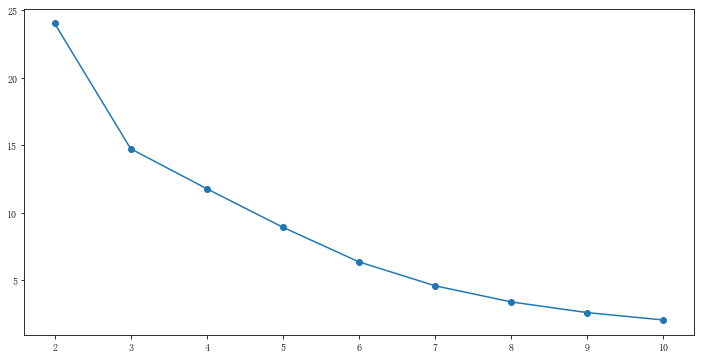

In [67]:
#elbow analysis
cluster_range = range( 2, 11 )
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( merged_var)
  cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

This figure indicates that 6 (i.e. knee in the plot) is the optimal number of k clusters for the features extracted from both years of satellite imagery. The number of 6 is therefore assigned to k to fit the kmeans clustering model, varying labels are subsequently matched to features dataset. 

In [68]:
np.random.seed(0)
k = 6

cls = pd.Series(KMeans(n_clusters=k, max_iter = 5000, n_init = 5000, random_state = 24).fit_predict(merged_var))

In [69]:
merged_var = merged_var.assign(lbls=cls)
merged_var.index = features_old_var.index
merged_var.head()#last columns represent class labels

,h_mean_x,s_mean_x,v_mean_x,h_std_x,s_std_x,v_std_x,h_skew_x,s_skew_x,v_skew_x,LBP0_x,...,LBP3_y,LBP4_y,LBP5_y,LBP6_y,LBP7_y,LBP8_y,LBP9_y,veg_mean_y,builtup_mean_y,lbls
Name,,,,,,,,,,,,,,,,,,,,,
嘉定区,0.793157,0.664179,0.151187,0.925457,0.679221,0.797052,0.676359,0.653469,0.786260,0.454091,...,0.735456,0.676314,0.609366,0.706912,0.675685,0.625297,0.073428,0.821121,0.972126,1
奉贤区,1.000000,0.990530,0.000000,0.906183,1.000000,0.987872,0.633860,1.000000,0.987806,0.915923,...,1.000000,0.994141,0.852811,1.000000,0.938629,0.493097,0.093827,0.020274,0.393903,3
宝山区,0.636975,0.359694,0.281144,1.000000,0.422465,0.580121,1.000000,0.417053,0.568198,0.286043,...,0.506561,0.410501,0.406220,0.494801,0.499487,0.726866,0.060848,0.856451,1.000000,2
崇明县,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.081547,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.581435,0
徐汇区,0.405751,0.437892,0.359299,0.419916,0.585825,0.558689,0.132057,0.619260,0.533603,0.392731,...,0.411980,0.183918,0.482370,0.502675,0.532805,0.732161,0.065949,0.834756,0.469369,2


### Interpretation
To understand the classification result, it is useful to create a choropleth map to visualise the spatial distribution of catogories by varing colours. In addition, the mean of each feature across each cluster can be calculated to uncover the feature differences among clusters.  

(290053.0696196473, 407301.6741094636, 3389866.639388826, 3533566.430983904)

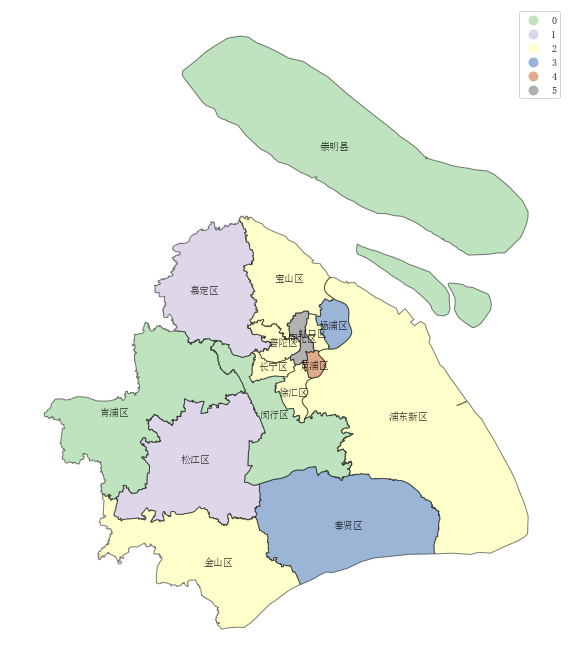

In [70]:
#plot clustering results for two different years
f, ax = plt.subplots(1, figsize=(10, 12))
#plot cluster results
poly = poly.drop('coords', axis = 1)
poly.assign(lbls=cls)\
     .plot(column='lbls', categorical=True, linewidth=1, alpha=0.5, ax=ax,legend = True,cmap = 'Accent', edgecolor = 'black')
#add labels for geographical units
poly['coords']=poly['geometry'].apply(lambda x:x.representative_point().coords[:])
poly['coords']=[coords[0] for coords in poly['coords']]
for idx, row in poly.iterrows():
    ax.annotate(s=row['Name'],xy=row['coords'],va='center',ha='center',alpha = 0.8, fontsize = 10)

#remove axes and set aspect ratio so that the data units are the same in every direction
ax.axis('off')
ax.axis('equal')

In [71]:
#calculate the mean of features for each class 
k6_mean = merged_var.groupby('lbls').mean()
k6_mean

,h_mean_x,s_mean_x,v_mean_x,h_std_x,s_std_x,v_std_x,h_skew_x,s_skew_x,v_skew_x,LBP0_x,...,LBP2_y,LBP3_y,LBP4_y,LBP5_y,LBP6_y,LBP7_y,LBP8_y,LBP9_y,veg_mean_y,builtup_mean_y
lbls,,,,,,,,,,,,,,,,,,,,,
0,0.113097,0.088470,0.837305,0.210939,0.118478,0.127151,0.316506,0.107534,0.124469,0.070301,...,0.140384,0.172060,0.158486,0.147885,0.115339,0.054215,0.939642,0.006619,0.959421,0.572280
1,0.803863,0.749195,0.146109,0.895068,0.749907,0.834330,0.633322,0.720249,0.823005,0.454389,...,0.760955,0.841492,0.838157,0.722830,0.794093,0.652172,0.600350,0.070401,0.714016,0.835832
2,0.426195,0.381664,0.384955,0.543494,0.481686,0.523486,0.450601,0.478586,0.504149,0.382849,...,0.510348,0.446913,0.309060,0.470514,0.466278,0.466282,0.748782,0.053443,0.852035,0.622854
3,0.949856,0.995265,0.004559,0.876415,0.991048,0.993936,0.676387,0.975688,0.993903,0.882717,...,0.964468,0.940470,0.808656,0.863404,0.987573,0.969315,0.488089,0.104292,0.010137,0.196952
4,0.721478,0.979475,0.114017,0.567528,0.998762,0.933619,0.244557,0.971796,0.925791,1.000000,...,0.907557,0.660840,0.487015,1.000000,0.950033,0.913027,0.521429,0.107485,0.713309,0.986139
5,0.471719,0.427622,0.373358,0.634773,0.554207,0.559062,0.554391,0.560426,0.534555,0.426212,...,0.570189,0.416572,0.116072,0.221324,0.445842,0.718360,0.000000,1.000000,0.895112,0.568988


In [72]:
#tidy up data table to make features into a column
k6_mean = k6_mean.stack()
k6_mean.head()

lbls          
0     h_mean_x    0.113097
      s_mean_x    0.088470
      v_mean_x    0.837305
      h_std_x     0.210939
      s_std_x     0.118478
dtype: float64

In [73]:
#convert multi-indices into single index
k6_mean = k6_mean.reset_index()
k6_mean.head()

,lbls,level_1,0
0,0,h_mean_x,0.113097
1,0,s_mean_x,0.088470
2,0,v_mean_x,0.837305
3,0,h_std_x,0.210939
4,0,s_std_x,0.118478


In [74]:
#renmae the columns
k6_mean = k6_mean.rename(columns = {'lbls': 'Class','level_1': 'Features', 0: 'Values'})
k6_mean.head()

,Class,Features,Values
0,0,h_mean_x,0.113097
1,0,s_mean_x,0.088470
2,0,v_mean_x,0.837305
3,0,h_std_x,0.210939
4,0,s_std_x,0.118478


In [75]:
#rename feature names in Feature column
old  = k6_mean.loc[k6_mean['Features'].str.contains('x') ==  True, :]
new  = k6_mean.loc[k6_mean['Features'].str.contains('y') ==  True, :]
#add a new column to represent time
old['Time'] = 1984
new['Time'] = 2019
#remove '_x' and '_y' in the table to make feature names for both years are the same
old['Features'] = old['Features'].str.replace('_x', '')
new['Features'] = new['Features'].str.replace('_y', '')

c:\users\meixu\anaconda3\envs\environment\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\meixu\anaconda3\envs\environment\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [76]:
#create a new dataframe to store the mean of each feature each cluster with time
data = pd.concat([old,new])
data.head()

,Class,Features,Values,Time
0,0,h_mean,0.113097,1984
1,0,s_mean,0.088470,1984
2,0,v_mean,0.837305,1984
3,0,h_std,0.210939,1984
4,0,s_std,0.118478,1984


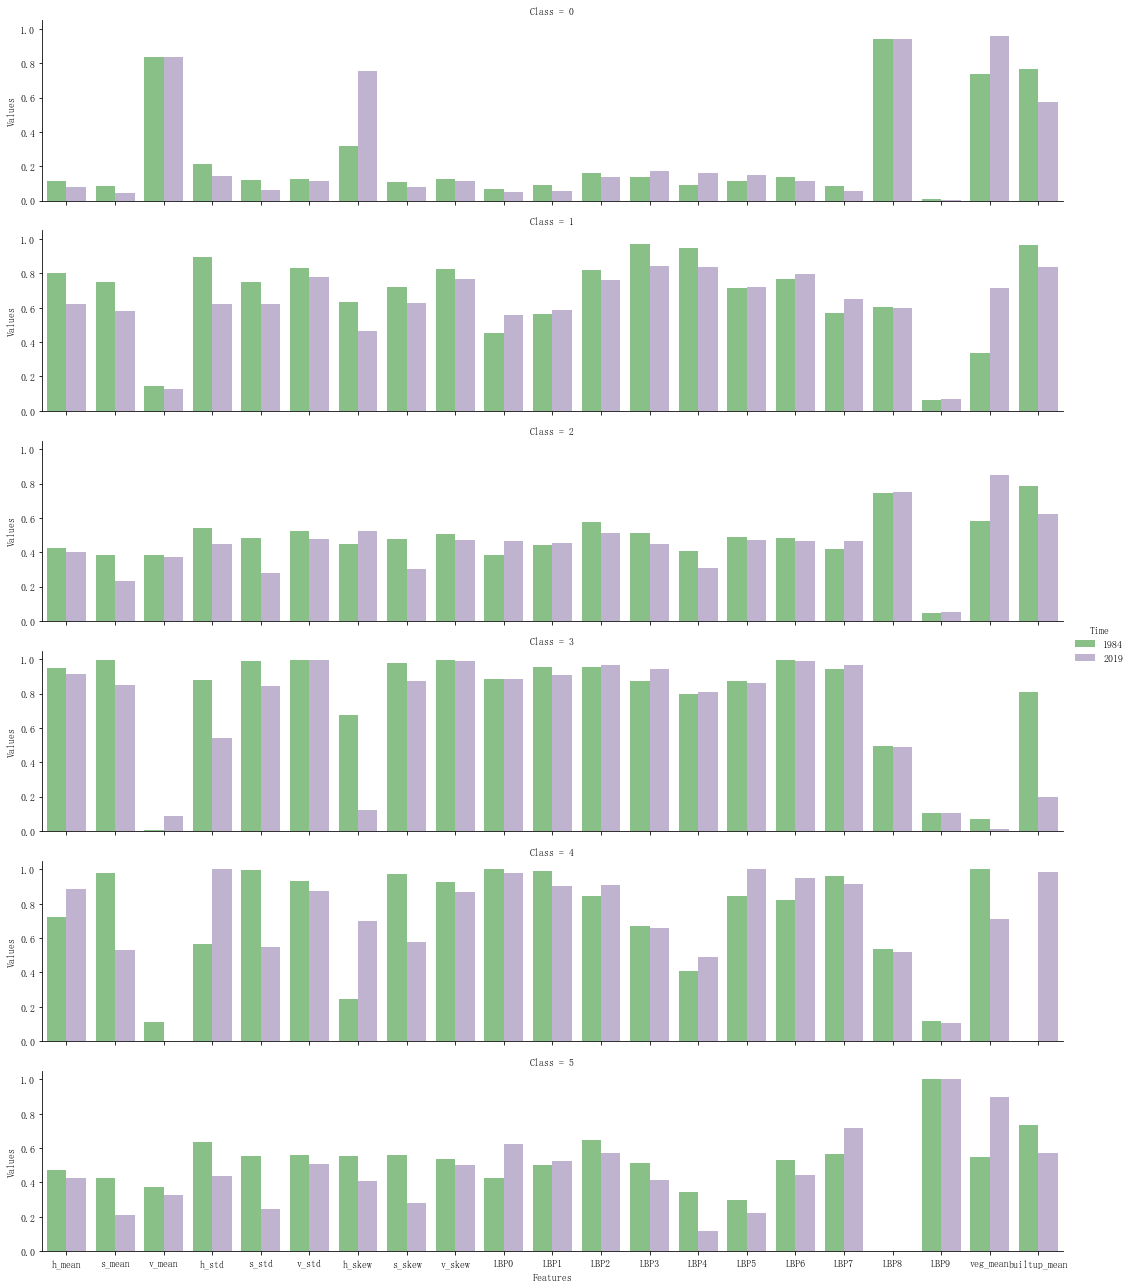

In [77]:
#visualise the distribution of mean values by features, class and time
sns.catplot( data = data, x = 'Features', y = 'Values',row = 'Class', hue = 'Time',kind = 'bar',\
            aspect = 5, height = 3, palette = 'Accent')

From the above two figures we can see a few striking differences across clusters, or classes. For class 4, only one administritive area (i.e. Huangpu area/黄浦区)is grouped, displayed in the middle of noth-east areas. The mean values for this class are mostly high in both years except a couple of features such as v_mean, LBP4 and LBP9 features. The brightness(v_mean) for this area is highly low and it became completely black over the time. H_mean value is high in both years, demonstrating that the dominating colour is blue, which represent water. This corresponds to famous area of The Bund, with its river skyline, which is part of this polygon. The vegatation built-up features indicate that this area has experienced a remarkable change, from more vegetation and few buildings to less vegatation and completely constructed/urbanisation. 

Class 1 and class 2 are relatively consistent compared to other classes, implying that the urban areas in purple and yellow colours almost remained unchanged during the past 35 years. Besides, these two classes have similar transformation such as more vegetation coverage and less buildings for the current year of 2019. However, class 2 has more brightness and more green colour based on v_mean, h_mean and veg_mean features, and class 1 has higher h_mean, h_std, h_skew and built-up_mean, implying these two areas have water covered and were highly constructed. 

Class 0 distributed at north and west areas in the map, which is extremly diverse and unique among all categories. It has the highest brightness features and LBP8 texture features, while the rest mean values of colour and texture features are highly low, especially for LBP9 where almost zero values in both years. The values for h_mean, s_mean and v_mean display that the primary colour for these areas is red with little gray and much brightness, representing that these areas include more bare ground or soil and thus probably rural areas. Adversely, class 5 has zero values for LBP8 but highest values for LBP9 in both years. It contains only one administritive area (i.e. Zhabei area/闸北区), surrounded by class 4 and class 2. Similarly, the area in class 5 has more vegatation but slightly less built-up areas over the past years. Class 3 contains two areas distributed at the south and surrounded by class 1 from the map. The feature values in class 5 are mostly extremely high, while the veg_mean and built-up_mean for current year are the least, thus indicating that these areas have more water over the time. 


### Conclusion


Urbanisation has significantly changed the interaction between humans and the surrounding environment, which poses new challenges in a multitude of fields including construction and city planning, hazard mitigation or disease control. It is essential to quantify and assess urbanisation over time to enable policy makers and planners to make informed decisions about future urban changes.This notebook shows the potential of open source satellite imagery to exploring urban changes and proposes a simple method framework for automatic data collection and features extraction to determine urbanisation over time using Python as a tool. 

### References

**Barsi, J. A.**, Lee, K., Kvaran, G., Markham, B. L., & Pedelty, J. A. (2014a). The spectral response of the Landsat-8 operational land imager. Remote Sensing, 6(10), 10232-10251.

**Barsi, J. A.**, Schott, J. R., Hook, S. J., Raqueno, N. G., Markham, B. L., & Radocinski, R. G. (2014b). Landsat-8 thermal infrared sensor (TIRS) vicarious radiometric calibration. Remote Sensing, 6(11), 11607-11626.

**Clark, D.** (2004). Urban world/global city. Routledge.

**Glaeser, E. and Henderson, J.V.**, 2017. Urban economics for the developing world: An introduction. Journal of Urban Economics, 98, pp.1-5.

**Knight, E. J., & Kvaran, G.** (2014). Landsat-8 operational land imager design, characterization and performance. Remote Sensing, 6(11), 10286-10305.

**Ministry of Civial Affairs of the People's Republic of China** (2018). Change of administrative divisions at or above the county level. [online] Available at: http://202.108.98.30/description?dcpid=1 [Accessed 10 Oct. 2019]

**Roy, D. P.**, Wulder, M. A., Loveland, T. R., Woodcock, C. E., Allen, R. G., Anderson, M. C., ... & Scambos, T. A. (2014). Landsat-8: Science and product vision for terrestrial global change research. Remote sensing of Environment, 145, 154-172.

**NASA**, 2019. Landsat Science. [online] Available at: https://landsat.gsfc.nasa.gov/ [Accessed 10 Sep. 2019]

**NASA**, 2000. Normalized Difference Vegatation Index (NDVI). [online] Available at: https://earthobservatory.nasa.gov/features/MeasuringVegetation/measuring_vegetation_2.php [Accessed 30 Oct. 2019]

**Noah Keen**, "Color Moments", February 2005.

**Ojala, T., Pietikäinen, M. and Harwood, D.** (1996), A Comparative Study of Texture Measures with Classification Based on Feature Distributions. Pattern Recognition 19(3):51-59.

**Pedregosa, F.**, Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Vanderplas, J. (2011). Scikit-learn: Machine learning in Python. Journal of machine learning research, 12(Oct), 2825-2830.

**United Nations, Department of Economic and Social Affairs, Population Division** (2019). World Urbanization
Prospects 2018: Highlights (ST/ESA/SER.A/421).

**Zha, Y., J. Gao, and S. Ni** (2003). "Use of Normalized Difference Built-Up Index in Automatically Mapping Urban Areas from TM Imagery." International Journal of Remote Sensing 24, 3, 583-594.